In [1]:
%load_ext autoreload
%autoreload 2

# Modelos Baseline
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Establecer performance baseline usando modelos simples

**Autor:** Estanislao  
**Fecha:** Diciembre 2024

---

## Modelos

1. **DummyRegressor**: Predice la media (baseline mínimo)
2. **LinearRegression**: Regresión lineal simple
3. **Ridge**: Regresión lineal regularizada (alpha=10)

**Estrategia anti-overfitting:**
- Usar SOLO features promedio (no horarias) → Reduce ~100 features a ~14
- Ratio samples/features: 309/14 = 22:1 (excelente)

## 1. Setup

In [2]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, entrenar_baseline, entrenar_baseline_hibrido

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [3]:
# Cargar dev y test
dev = pd.read_csv('../data/processed/dev.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

print(f"Dev:  {dev.shape}")
print(f"Test: {test.shape}")

# Targets de regresión
targets_reg = [
    'altura_max_m',
    'ganancia_altura_m',
    'duracion_min',
    'distancia_km',
    'velocidad_promedio_kmh',
    'num_termicas',
    'intensidad_termicas_mean_ms',
    'tiempo_en_termicas_min',
    'tasa_ascenso_mean_ms'
]

print(f"\nTargets: {len(targets_reg)}")

Dev:  (309, 181)
Test: (78, 181)

Targets: 9


## 3. Preparar Features

In [4]:
# Separar features de targets - MODO SIMPLE (solo promedios)
X_dev, y_dev, X_test, y_test = preparar_datos(dev, test, targets_reg, modo='simple')

print(f"\nFeatures: {X_dev.shape[1]}")
print(f"Samples - Dev: {X_dev.shape[0]}, Test: {X_test.shape[0]}")
print(f"\n✓ Ratio samples/features: {X_dev.shape[0]/X_dev.shape[1]:.1f}:1 (excelente para baseline)")

print(f"\nFeatures disponibles:")
for i, col in enumerate(X_dev.columns, 1):
    print(f"  {i:2d}. {col}")


Features: 14
Samples - Dev: 309, Test: 78

✓ Ratio samples/features: 22.1:1 (excelente para baseline)

Features disponibles:
   1. lat_despegue
   2. lon_despegue
   3. hora_despegue_decimal
   4. solar_rad_avg
   5. precipitation_avg
   6. temp_2m_avg
   7. cloud_cover_avg
   8. wind_u_avg
   9. wind_v_avg
  10. pressure_avg
  11. boundary_layer_height_avg
  12. cape_avg
  13. skin_temp_avg
  14. wind_speed_avg


## 4. Entrenar Modelos Baseline

In [5]:
# Definir modelos
modelos = {
    'DummyRegressor': DummyRegressor,
    'LinearRegression': LinearRegression,
    'Ridge': lambda: Ridge(alpha=10.0)
}

# Entrenar
df_resultados, modelos_entrenados = entrenar_baseline(
    X_dev, y_dev, X_test, y_test, 
    targets_reg, modelos
)

print("\n" + "="*70)
print("BASELINE COMPLETADO")
print("="*70)


DummyRegressor
altura_max_m:
  Dev:  R² = 0.0000, MAE = 426.25, RMSE = 552.20
  Test: R² = -0.0145, MAE = 429.23, RMSE = 561.10
ganancia_altura_m:
  Dev:  R² = 0.0000, MAE = 408.14, RMSE = 529.87
  Test: R² = -0.0189, MAE = 401.38, RMSE = 526.61
duracion_min:
  Dev:  R² = 0.0000, MAE = 56.09, RMSE = 71.70
  Test: R² = -0.0008, MAE = 55.52, RMSE = 73.23
distancia_km:
  Dev:  R² = 0.0000, MAE = 135.22, RMSE = 170.07
  Test: R² = -0.0001, MAE = 135.33, RMSE = 170.70
velocidad_promedio_kmh:
  Dev:  R² = 0.0000, MAE = 14.68, RMSE = 18.31
  Test: R² = -0.0039, MAE = 14.73, RMSE = 18.86
num_termicas:
  Dev:  R² = 0.0000, MAE = 57.08, RMSE = 69.33
  Test: R² = -0.0035, MAE = 57.12, RMSE = 69.60
intensidad_termicas_mean_ms:
  Dev:  R² = 0.0000, MAE = 0.38, RMSE = 0.55
  Test: R² = -0.0595, MAE = 0.33, RMSE = 0.45
tiempo_en_termicas_min:
  Dev:  R² = 0.0000, MAE = 22.43, RMSE = 28.71
  Test: R² = -0.0010, MAE = 21.94, RMSE = 29.11
tasa_ascenso_mean_ms:
  Dev:  R² = 0.0000, MAE = 0.64, RMSE = 1.

## 5. Resumen de Resultados

In [6]:
# Tabla pivot: R² en Test
df_test = df_resultados[df_resultados['split'] == 'Test'].copy()
df_pivot = df_test.pivot(index='target', columns='modelo', values='R2')

print("\n" + "="*70)
print("R² en Test Set")
print("="*70)
print(df_pivot.sort_values('Ridge', ascending=False).to_string())

# Mejores targets
print("\n" + "="*70)
print("Top 3 Targets (Ridge)")
print("="*70)
top3 = df_pivot.nlargest(3, 'Ridge')
for target in top3.index:
    r2_ridge = top3.loc[target, 'Ridge']
    r2_lr = top3.loc[target, 'LinearRegression']
    mejora = r2_ridge - r2_lr
    print(f"  {target}:")
    print(f"    Ridge: {r2_ridge:.4f}, LR: {r2_lr:.4f}, Mejora: {mejora:+.4f}")


R² en Test Set
modelo                       DummyRegressor  LinearRegression     Ridge
target                                                                 
duracion_min                      -0.000850          0.661473  0.652251
distancia_km                      -0.000058          0.638503  0.624487
tiempo_en_termicas_min            -0.001028          0.616307  0.607364
velocidad_promedio_kmh            -0.003904          0.454043  0.444225
altura_max_m                      -0.014452          0.430210  0.433295
ganancia_altura_m                 -0.018850          0.349644  0.354265
num_termicas                      -0.003529          0.161922  0.161552
tasa_ascenso_mean_ms              -0.034238         -0.051156 -0.049438
intensidad_termicas_mean_ms       -0.059496         -0.093940 -0.097071

Top 3 Targets (Ridge)
  duracion_min:
    Ridge: 0.6523, LR: 0.6615, Mejora: -0.0092
  distancia_km:
    Ridge: 0.6245, LR: 0.6385, Mejora: -0.0140
  tiempo_en_termicas_min:
    Ridge: 0.6074

## 6. Visualización

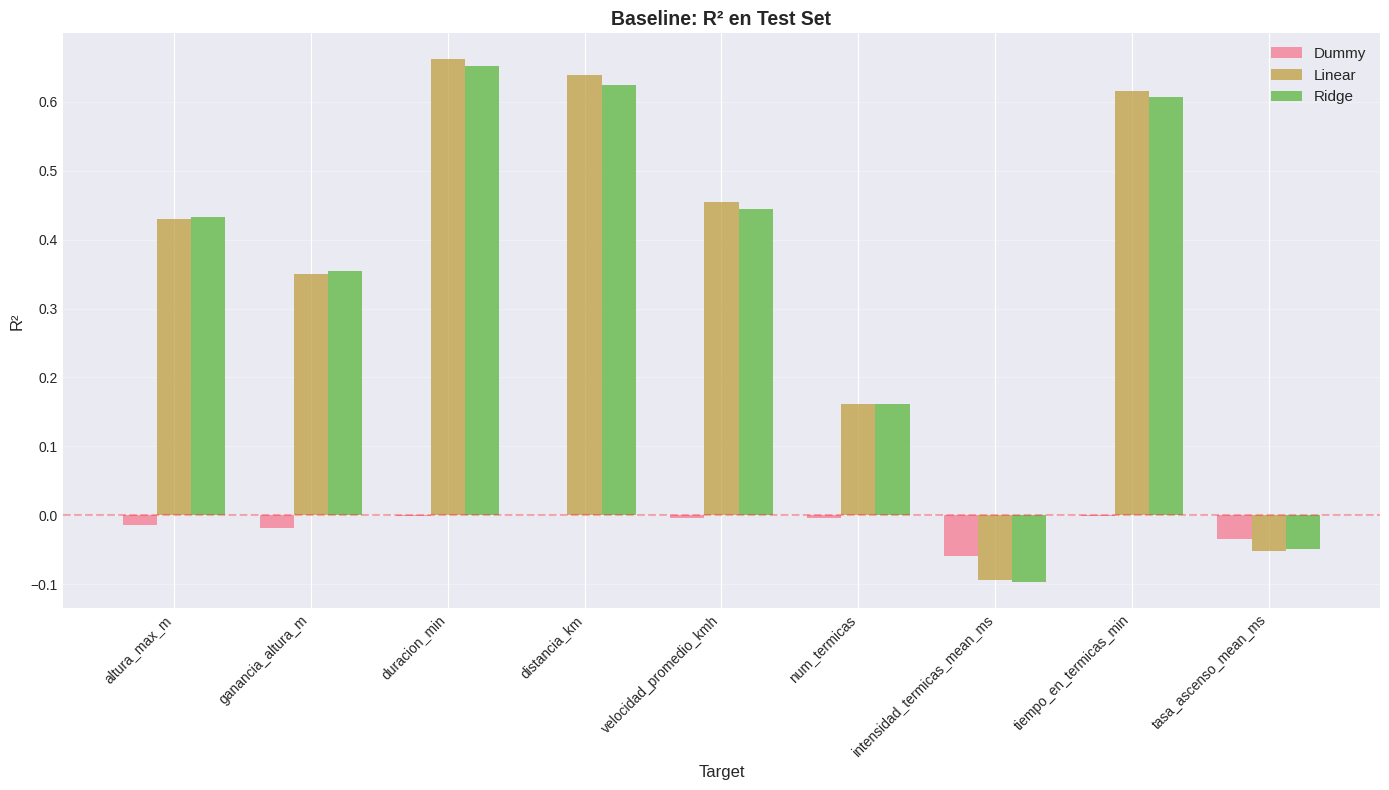

In [7]:
# Gráfico comparativo
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.25

dummy = [df_pivot.loc[t, 'DummyRegressor'] for t in targets_reg]
lr = [df_pivot.loc[t, 'LinearRegression'] for t in targets_reg]
ridge = [df_pivot.loc[t, 'Ridge'] for t in targets_reg]

ax.bar(x - width, dummy, width, label='Dummy', alpha=0.7)
ax.bar(x, lr, width, label='Linear', alpha=0.7)
ax.bar(x + width, ridge, width, label='Ridge', alpha=0.7)

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R²', fontsize=12)
ax.set_title('Baseline: R² en Test Set', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Modelo Híbrido (Anti R² Negativo)

**Estrategia:** Si Ridge da R² < 0 en CV → usar DummyRegressor

Esto garantiza que **nunca** tengamos R² negativo en test.

In [8]:
from sklearn.linear_model import Ridge

# Entrenar modelo híbrido
df_hibrido, modelos_hibridos = entrenar_baseline_hibrido(
    X_dev, y_dev, X_test, y_test,
    targets_reg,
    modelo_principal=lambda: Ridge(alpha=10.0),
    usar_cv=True
)


MODELO HÍBRIDO - Anti R² Negativo
Estrategia: Si modelo da R² < 0 → usar DummyRegressor (R² = 0)

altura_max_m:
  CV R²: 0.2701 → Ridge
  Dev:  R² = 0.3723
  Test: R² = 0.4333
ganancia_altura_m:
  CV R²: 0.2173 → Ridge
  Dev:  R² = 0.3292
  Test: R² = 0.3543
duracion_min:
  CV R²: 0.4022 → Ridge
  Dev:  R² = 0.4703
  Test: R² = 0.6523
distancia_km:
  CV R²: 0.3756 → Ridge
  Dev:  R² = 0.4592
  Test: R² = 0.6245
velocidad_promedio_kmh:
  CV R²: 0.1876 → Ridge
  Dev:  R² = 0.2987
  Test: R² = 0.4442
num_termicas:
  CV R²: 0.1389 → Ridge
  Dev:  R² = 0.2072
  Test: R² = 0.1616
intensidad_termicas_mean_ms:
  CV R²: -0.1170 → Dummy (R²<0)
  Dev:  R² = 0.0000
  Test: R² = -0.0595
  ⚠️ R² negativo detectado - REVISAR
tiempo_en_termicas_min:
  CV R²: 0.3844 → Ridge
  Dev:  R² = 0.4515
  Test: R² = 0.6074
tasa_ascenso_mean_ms:
  CV R²: -0.0939 → Dummy (R²<0)
  Dev:  R² = 0.0000
  Test: R² = -0.0342
  ⚠️ R² negativo detectado - REVISAR


### Comparación: Ridge vs Híbrido

In [9]:
# Comparar resultados
df_test_ridge = df_resultados[(df_resultados['split']=='Test') & 
                               (df_resultados['modelo']=='Ridge')].copy()
df_test_hibrido = df_hibrido[df_hibrido['split']=='Test'].copy()

print("="*70)
print("COMPARACIÓN: Ridge vs Híbrido (Test)")
print("="*70)

for target in targets_reg:
    r2_ridge = df_test_ridge[df_test_ridge['target']==target]['R2'].values[0]
    r2_hibrido = df_test_hibrido[df_test_hibrido['target']==target]['R2'].values[0]
    modelo = df_test_hibrido[df_test_hibrido['target']==target]['modelo'].values[0]
    
    mejora = r2_hibrido - r2_ridge
    
    print(f"\n{target}:")
    print(f"  Ridge:   {r2_ridge:.4f}")
    print(f"  Híbrido: {r2_hibrido:.4f} ({modelo})")
    
    if mejora > 0:
        print(f"  ✓ Mejora: {mejora:+.4f}")
    elif r2_hibrido >= 0 and r2_ridge < 0:
        print(f"  ✓ Corregido: {r2_ridge:.4f} → {r2_hibrido:.4f}")

COMPARACIÓN: Ridge vs Híbrido (Test)

altura_max_m:
  Ridge:   0.4333
  Híbrido: 0.4333 (Ridge)

ganancia_altura_m:
  Ridge:   0.3543
  Híbrido: 0.3543 (Ridge)

duracion_min:
  Ridge:   0.6523
  Híbrido: 0.6523 (Ridge)

distancia_km:
  Ridge:   0.6245
  Híbrido: 0.6245 (Ridge)

velocidad_promedio_kmh:
  Ridge:   0.4442
  Híbrido: 0.4442 (Ridge)

num_termicas:
  Ridge:   0.1616
  Híbrido: 0.1616 (Ridge)

intensidad_termicas_mean_ms:
  Ridge:   -0.0971
  Híbrido: -0.0595 (Dummy (R²<0))
  ✓ Mejora: +0.0376

tiempo_en_termicas_min:
  Ridge:   0.6074
  Híbrido: 0.6074 (Ridge)

tasa_ascenso_mean_ms:
  Ridge:   -0.0494
  Híbrido: -0.0342 (Dummy (R²<0))
  ✓ Mejora: +0.0152


## 8. Guardar Resultados

In [10]:
# Guardar métricas
df_resultados.to_csv('../data/processed/resultados_baseline.csv', index=False)
df_hibrido.to_csv('../data/processed/resultados_hibrido.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/resultados_baseline.csv")
print("  - data/processed/resultados_hibrido.csv")
print("  - data/processed/baseline_comparison.png")
print("\n" + "="*70)
print("\n✓ MODELO HÍBRIDO = Sin R² negativos")
print("  Usa Ridge cuando funciona, Dummy cuando no")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/resultados_baseline.csv
  - data/processed/resultados_hibrido.csv
  - data/processed/baseline_comparison.png


✓ MODELO HÍBRIDO = Sin R² negativos
  Usa Ridge cuando funciona, Dummy cuando no
